#### trOCR & detectron pipeline demo

In [32]:
# Importing libraries
import os 
import glob 
import time
import pandas as pd
from PIL import Image
import json
import random
import cv2
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
from datasets import load_metric

from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import default_argument_parser
from detectron2.engine import default_setup
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

from transformers import TrOCRProcessor
from transformers import VisionEncoderDecoderModel

#### Loading up database

In [33]:
def load_list_from_file(file_name):
    my_list = []
    with open(file_name, 'r') as file:
        for line in file:
            my_list.append(json.loads(line))
    return my_list

file_name = 'bounding-box.txt'
df = load_list_from_file(file_name)
new_classese = pd.read_csv('csvs/new_classes.csv')

In [34]:
# Function to split data in test and train
def split_data(lst, split):
    n = len(lst)
    n_20_percent = int(n * 0.05)
    n_80_percent = n - n_20_percent
    test = random.sample(lst, n_20_percent)
    train = [item for item in lst if item not in test]
    if split == 'train':
        return train
    
    if split == 'test':
        return test

# Function to register dataset
def register_dataset(name, dirname):
    if name not in DatasetCatalog.list():
        DatasetCatalog.register(name, lambda: split_data(df, 'train'))
        
    MetadataCatalog.get(name).set(
        thing_classes=list(new_classese['classes']), split='train', dirname= dirname
    )

In [35]:
# Loading datasets
register_dataset('new_docs_dataset_train', dirname = 'datasets')

#### Setting up configs

In [36]:
# Setting up cfg for Predictions
def setup_cfg(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.DATASETS.TRAIN = ("new_docs_dataset_train",)
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(cfg, args)
    return cfg

# Setting up predictors
parser = default_argument_parser()
args = parser.parse_args("--config-file tuned-detectronv2/config.yaml MODEL.WEIGHTS tuned-detectronv2/model_final.pth".split())
cfg = setup_cfg(args)

predictor = DefaultPredictor(cfg)

[04/16 22:22:54 detectron2]: Rank of current process: 0. World size: 1
[04/16 22:22:54 detectron2]: Environment info:
-------------------------------  ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
sys.platform                     win32
Python                           3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]
numpy                            1.23.5
detectron2                       0.6 @C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\detectron2
Compiler                         MSVC 193532217
CUDA compiler                    not available
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          1.13.1+cu117 @C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-p

#### Importing initial image

0.519240140914917
data/parte_amistoso_9_26_7.jpg


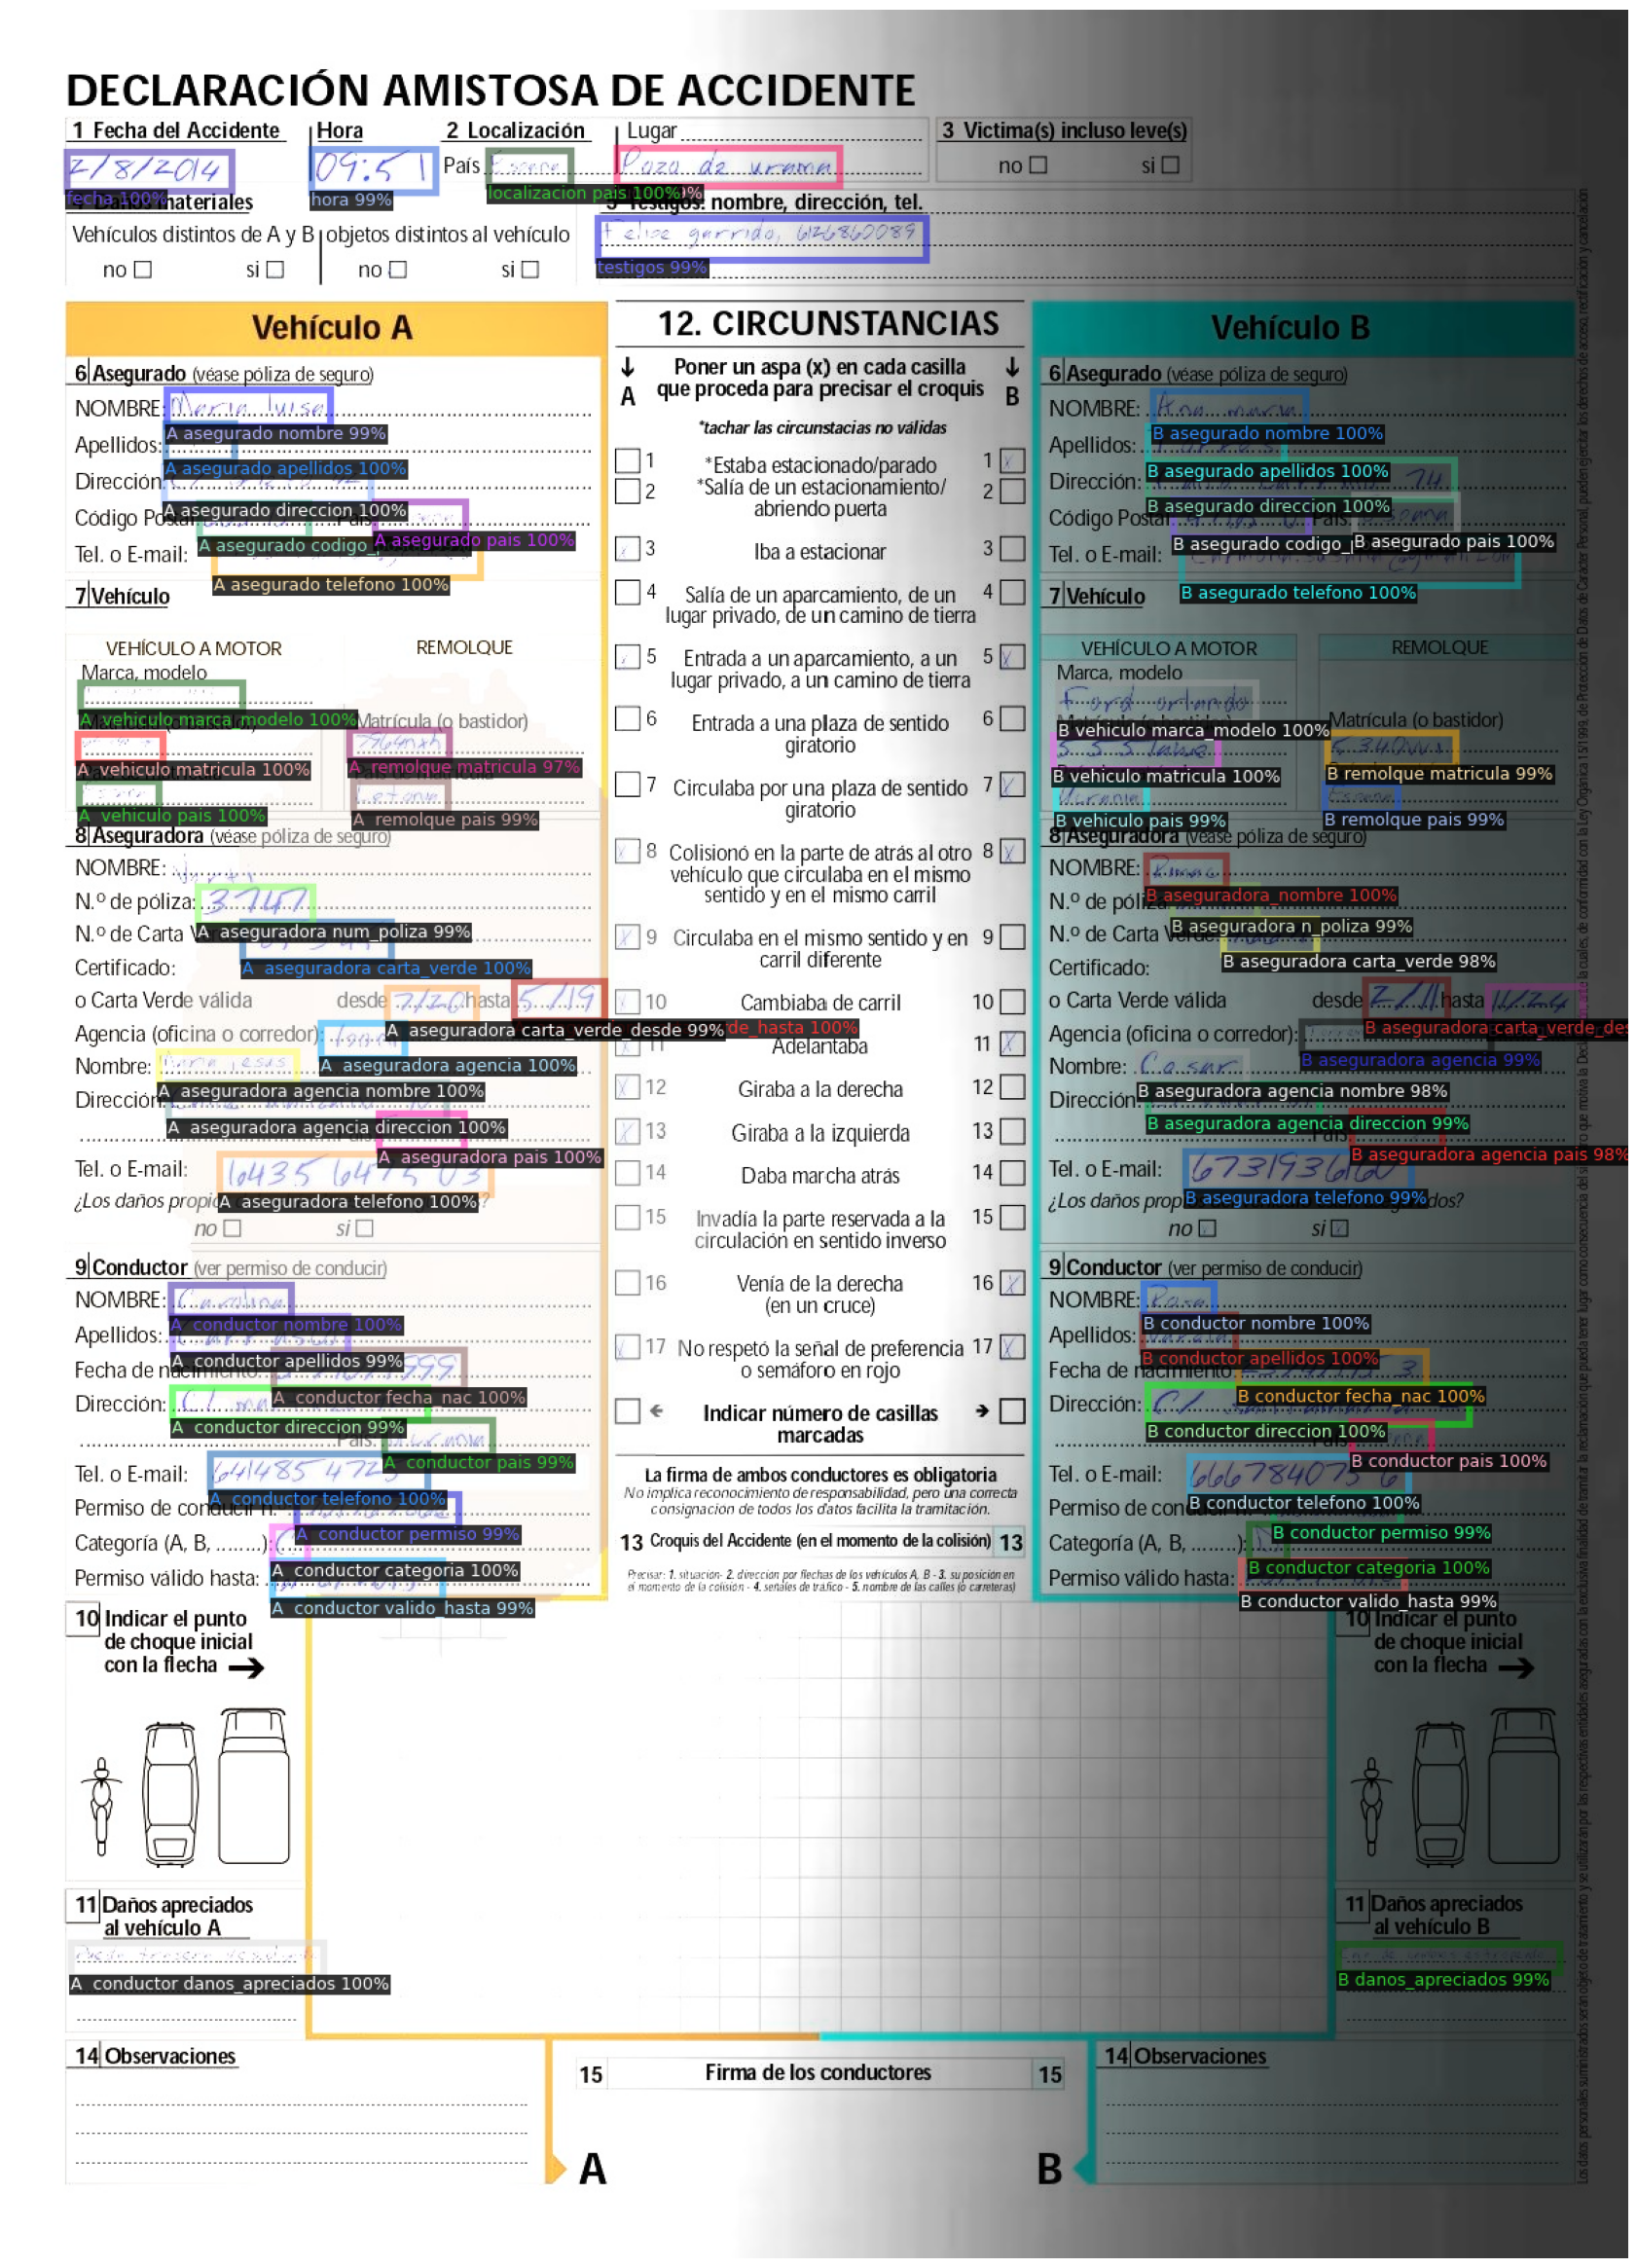

In [37]:
import os

# Create a directory to save the bounding box images
if not os.path.exists('bounding_box_images'):
    os.makedirs('bounding_box_images')
else:
    # Remove any existing files in the directory
    for file in os.listdir('bounding_box_images'):
        os.remove(os.path.join('bounding_box_images', file))

files = []
for dict in split_data(df, 'test'):
    files.append(dict['file_name'])

# Set sample size as wanted
sample_size = 1
for file,_ in zip(files,range(sample_size)):
    im = cv2.imread(file)
    MetadataCatalog.get("new_docs_dataset_train").thing_classes = list(new_classese['classes'])
    start_time = time.time()
    outputs = predictor(im)
    print(time.time()- start_time)

    v = Visualizer(im[:, :, ::-1], metadata=MetadataCatalog.get("new_docs_dataset_train"), scale=1)
    instances = outputs["instances"].to("cpu")
    v = v.draw_instance_predictions(instances)
    print(file)
    figure(num=None, figsize=(30, 30), dpi=100, facecolor='w', edgecolor='k')
    plt.axis("off")
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()
        
    # Save each bounding box as a .jpg file with its name being equal to the predicted class
    for i in range(len(instances)):
        class_name = MetadataCatalog.get("new_docs_dataset_train").thing_classes[instances.pred_classes[i]]
        bbox = instances.pred_boxes.tensor[i].cpu().numpy().astype(int)  # convert bounding box coordinates to integers
        box_image = im[bbox[1]:bbox[3], bbox[0]:bbox[2]]
        cv2.imwrite(f'bounding_box_images/{class_name}.jpg', box_image)



In [43]:
# Importing models
cer_metric = load_metric("cer")
model = VisionEncoderDecoderModel.from_pretrained("tuned-seq2seqv1")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-handwritten")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [44]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\generation\utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


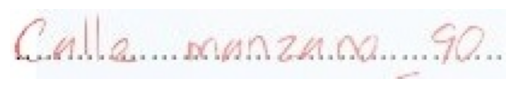

Campo:  A  aseguradora agencia direccion
Calle manzano 90


C:\Users\ismae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\transformers\generation\utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 64 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


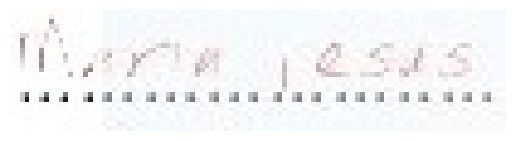

Campo:  A  aseguradora agencia nombre
Maria jesus


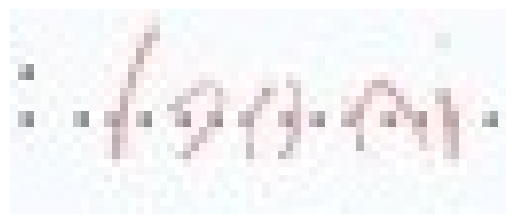

Campo:  A  aseguradora agencia
Espana


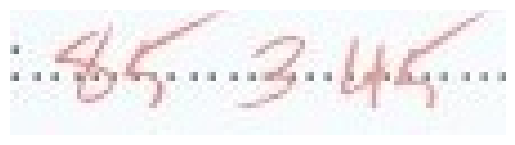

Campo:  A  aseguradora carta_verde
85345


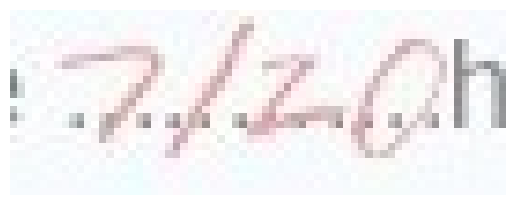

Campo:  A  aseguradora carta_verde_desde
7/20h


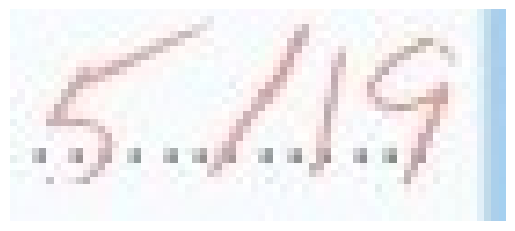

Campo:  A  aseguradora carta_verde_hasta
5/19


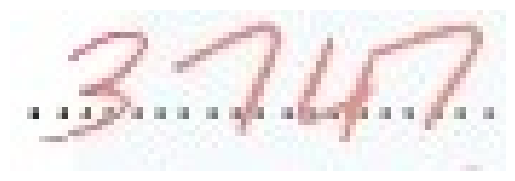

Campo:  A  aseguradora num_poliza
3747


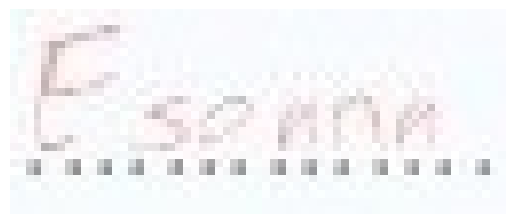

Campo:  A  aseguradora pais
Espana


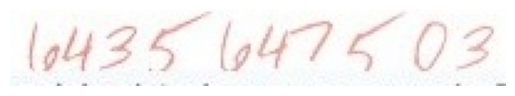

Campo:  A  aseguradora telefono
6435647503


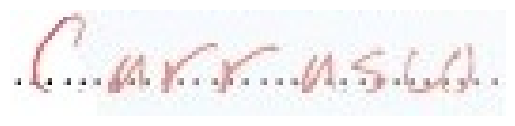

Campo:  A  conductor apellidos
Carrasco


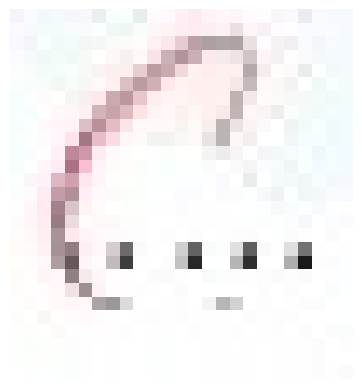

Campo:  A  conductor categoria
C


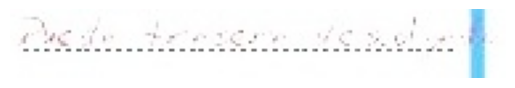

Campo:  A  conductor danos_apreciados
Rueda de escape descolgado


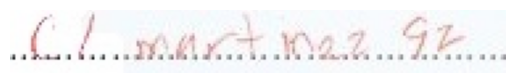

Campo:  A  conductor direccion
C/ martinez 92


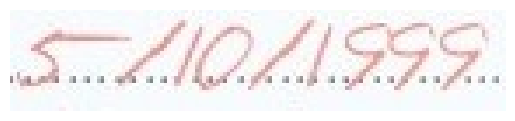

Campo:  A  conductor fecha_nac
5/10/1999


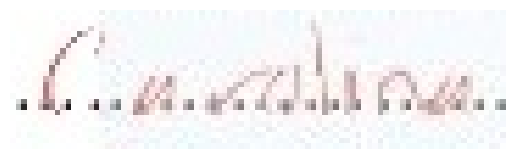

Campo:  A  conductor nombre
Carolina


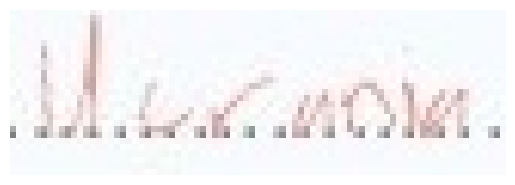

Campo:  A  conductor pais
Ucrania


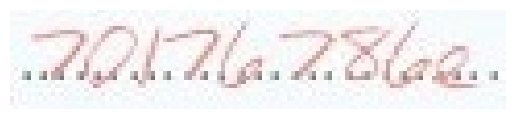

Campo:  A  conductor permiso
70176786e


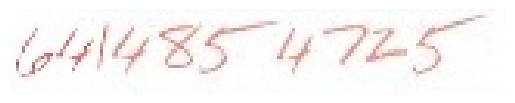

Campo:  A  conductor telefono
6414854725


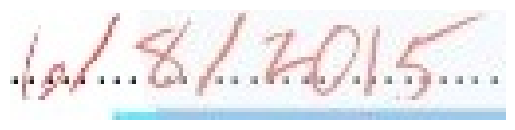

Campo:  A  conductor valido_hasta
6/8/2015


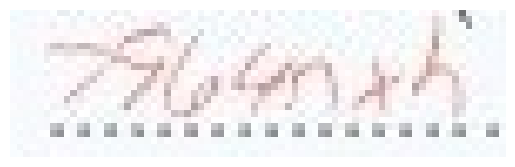

Campo:  A  remolque matricula
7964nxh


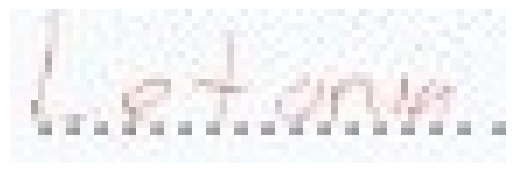

Campo:  A  remolque pais
Letonia


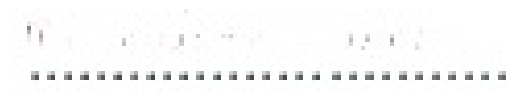

Campo:  A  vehiculo marca_modelo
MOLINA DELISA


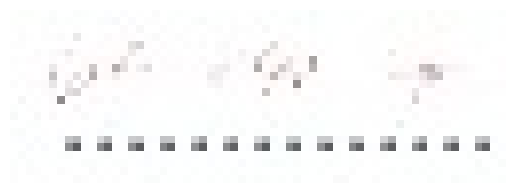

Campo:  A  vehiculo matricula
MOLINA


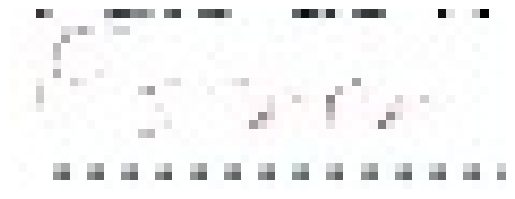

Campo:  A  vehiculo pais
Espana


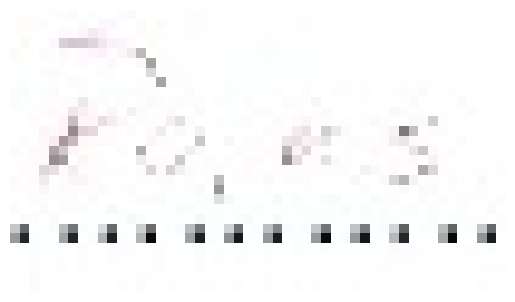

Campo:  A asegurado apellidos
Rojas


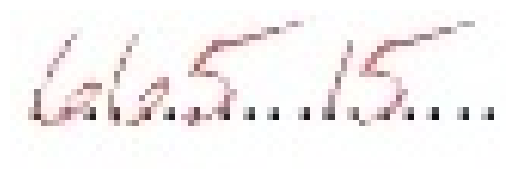

Campo:  A asegurado codigo_postal
66515


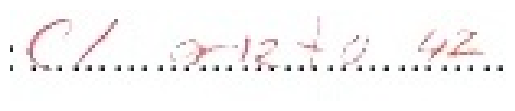

Campo:  A asegurado direccion
C/ prieto 42


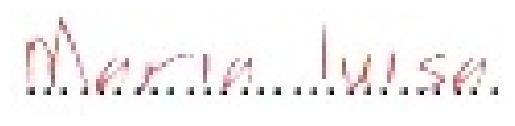

Campo:  A asegurado nombre
Maria luisa


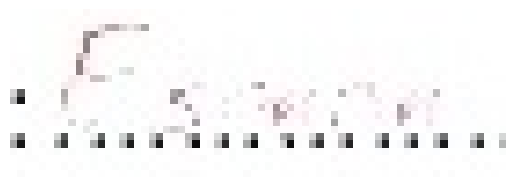

Campo:  A asegurado pais
Espana


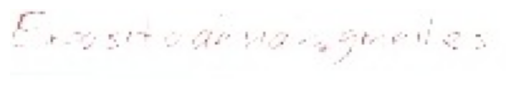

Campo:  A asegurado telefono
Exposito.david@gmail.es


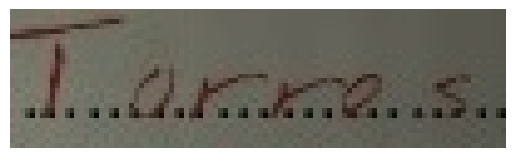

Campo:  B asegurado apellidos
Torres


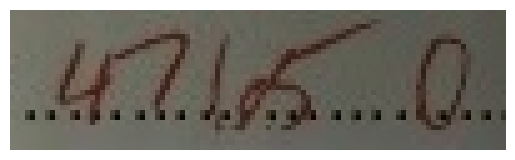

Campo:  B asegurado codigo_postal
47150


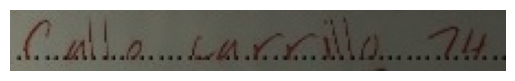

Campo:  B asegurado direccion
Calle carrillo 74


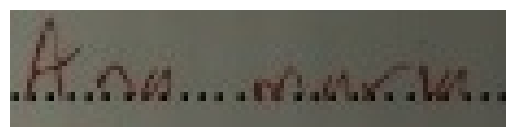

Campo:  B asegurado nombre
Ana maria


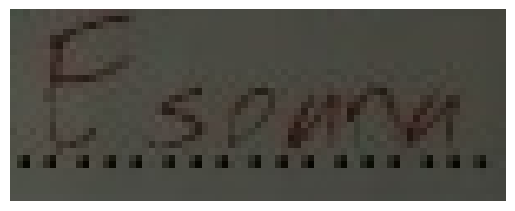

Campo:  B asegurado pais
Espana


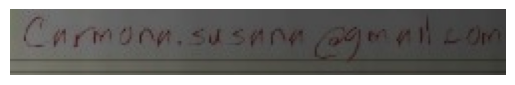

Campo:  B asegurado telefono
Carmona.susana@gmail.com


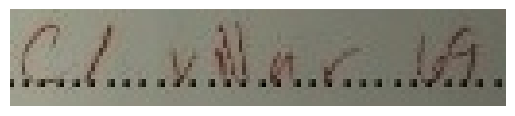

Campo:  B aseguradora agencia direccion
C/ villar 69


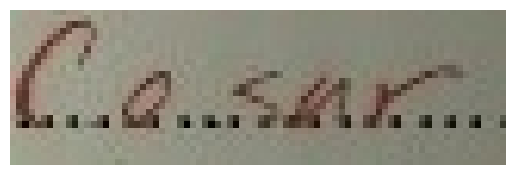

Campo:  B aseguradora agencia nombre
Cesar


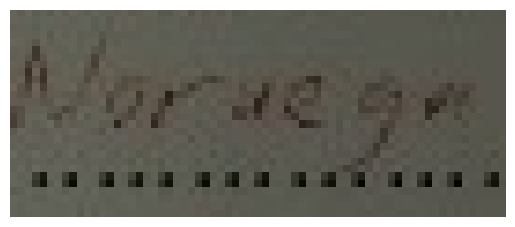

Campo:  B aseguradora agencia pais
Noruega


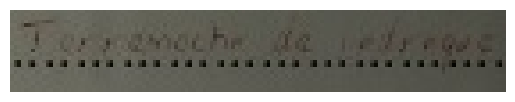

Campo:  B aseguradora agencia
Torre.monta de johrado


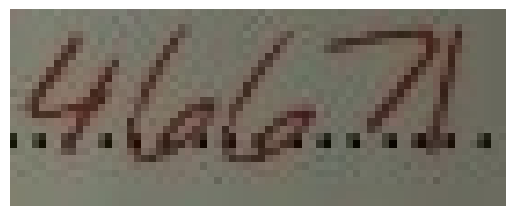

Campo:  B aseguradora carta_verde
46671


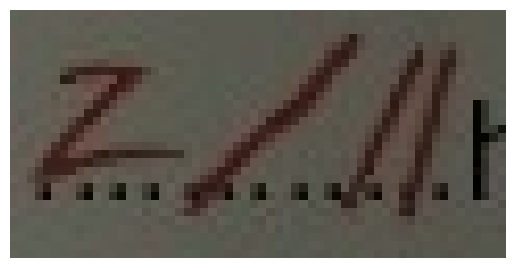

Campo:  B aseguradora carta_verde_desde
2/11


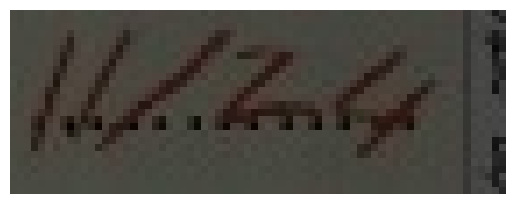

Campo:  B aseguradora carta_verde_hasta
11/24


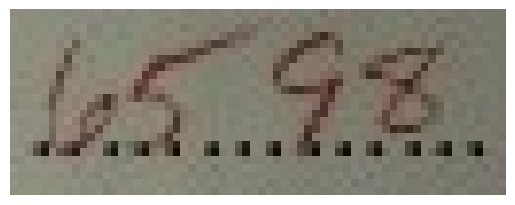

Campo:  B aseguradora n_poliza
6598


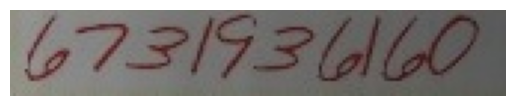

Campo:  B aseguradora telefono
6731936160


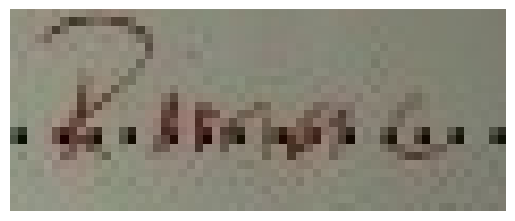

Campo:  B aseguradora_nombre
Rimac


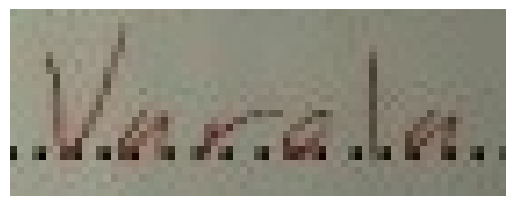

Campo:  B conductor apellidos
Varela


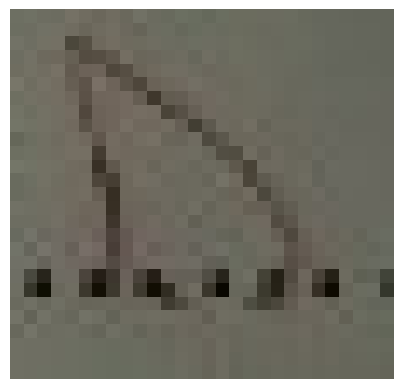

Campo:  B conductor categoria
D


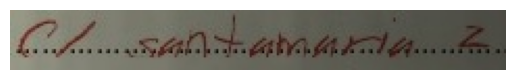

Campo:  B conductor direccion
C/ mateaaria 5


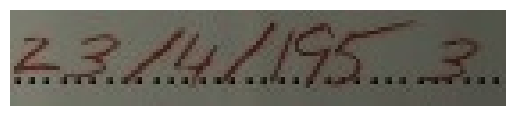

Campo:  B conductor fecha_nac
23/4/1953


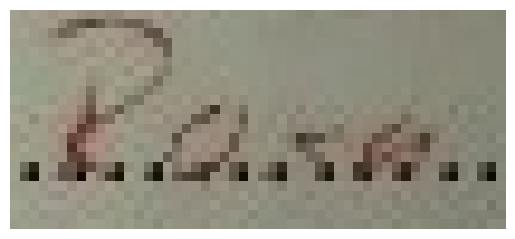

Campo:  B conductor nombre
Rosa


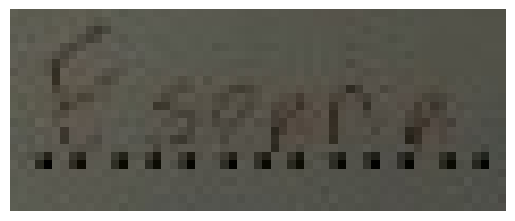

Campo:  B conductor pais
Espana


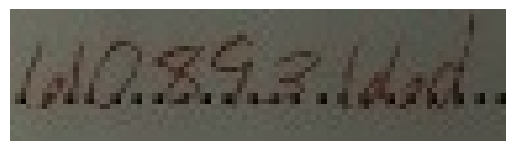

Campo:  B conductor permiso
61089366d


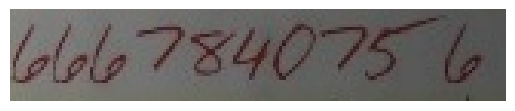

Campo:  B conductor telefono
6667840756


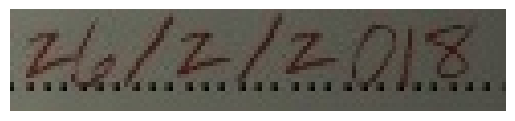

Campo:  B conductor valido_hasta
26/2/2018


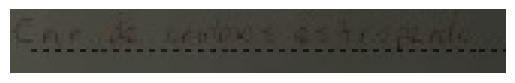

Campo:  B danos_apreciados
Castillo.andan@hotmail.es


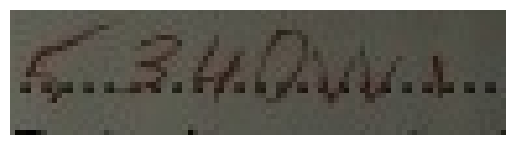

Campo:  B remolque matricula
5340vvis


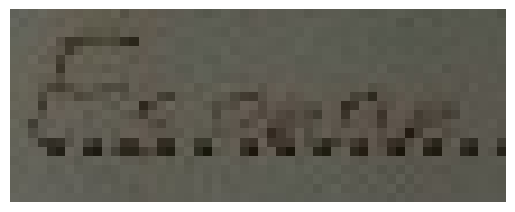

Campo:  B remolque pais
Espana


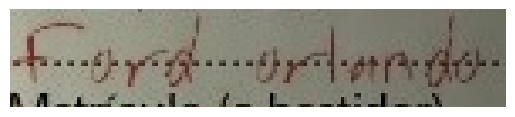

Campo:  B vehiculo marca_modelo
Ford orlando


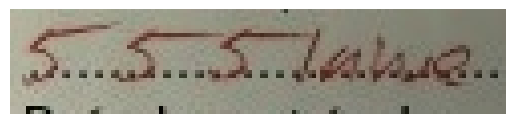

Campo:  B vehiculo matricula
5551awe


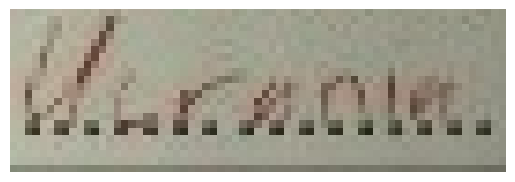

Campo:  B vehiculo pais
Ucrania


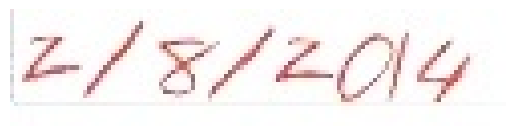

Campo:  fecha
2/8/2014


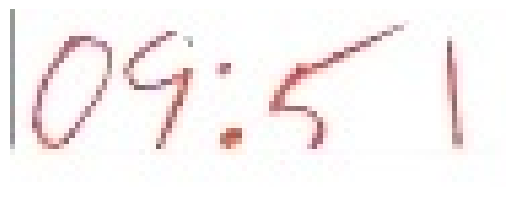

Campo:  hora
109:51


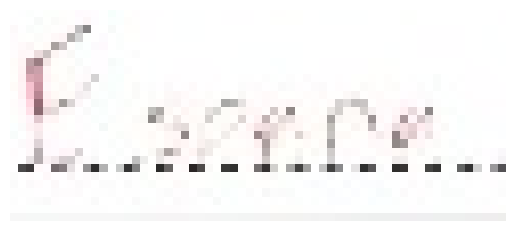

Campo:  localizacion pais
Espana


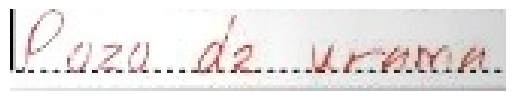

Campo:  lugar
Pozo de urama


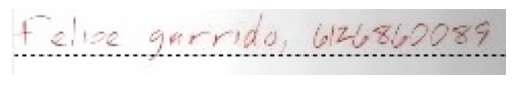

Campo:  testigos
Felipe garrido, 612660089


In [45]:
files = []
classes = pd.read_csv('csvs/new_classes.csv')
def retrieve_sample(path):
    image = Image.open('bounding_box_images/' + path).convert("RGB")
    # calling the processor is equivalent to calling the feature extractor
    pixel_values = processor(image, return_tensors="pt").pixel_values
    return image, pixel_values

def add_value_to_specific(df, column_to_check, value_to_check, column_to_add, value_to_add):
    df.loc[df[column_to_check] == value_to_check, column_to_add] = value_to_add
    return df

def generate_many():
    boxes = pd.DataFrame()
    boxes['classes'] = classes['classes'] 

    for file in os.listdir('bounding_box_images'):
        image, pixel_values = retrieve_sample(file)
        generated_ids = model.generate(pixel_values)
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        add_value_to_specific(boxes, 'classes', file.split('.jpg')[0], 'texto', generated_text)
        plt.imshow(image)
        plt.axis("off")
        plt.show()
        print('Campo: ', file.split('.jpg')[0])
        print(generated_text)
    return boxes

final_csv = generate_many()

#### Final CSV

In [46]:
final_csv

classes                      texto
0             A  aseguradora agencia                     Espana
1   A  aseguradora agencia direccion           Calle manzano 90
2      A  aseguradora agencia nombre                Maria jesus
3         A  aseguradora carta_verde                      85345
4   A  aseguradora carta_verde_desde                      7/20h
..                               ...                        ...
62                             fecha                   2/8/2014
63                              hora                     109:51
64                 localizacion pais                     Espana
65                             lugar              Pozo de urama
66                          testigos  Felipe garrido, 612660089

[67 rows x 2 columns]

In [ ]:
final_csv.to_csv('csvs/final.csv')